In [11]:
import pandas as pd

## BERT

In [12]:
import torch
from transformers import BertModel, BertTokenizer

In [28]:
train_df = pd.read_csv('data/user_concat_text_10_train.csv', sep=';')
test_df = pd.read_csv('data/user_concat_text_10_test.csv', sep=';')

In [15]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def generate_embedding(input_text):
    # Tokenize input text
    input_ids = tokenizer.encode_plus(input_text, 
                                      add_special_tokens=True, 
                                      return_tensors="pt", 
                                      truncation=True,
                                      max_length=512,
                                      padding='max_length')  # Adjust max_length
    # Move inputs to GPU
    input_ids = input_ids.to(device)
    with torch.no_grad():
        # Move model to GPU
        model.to(device)
        outputs = model(**input_ids)  # Pass the tokenized inputs as keyword arguments
        embeddings = outputs.last_hidden_state  # Extract the embeddings
    return embeddings

In [9]:
generate_embedding('We loved this place and are sad that it is closed')

tensor([[[-0.0280, -0.0087,  0.3377,  ...,  0.0632,  0.6283,  0.0244],
         [ 0.4234, -0.1273, -0.4582,  ..., -0.3916,  1.2081, -0.4115],
         [ 1.0119,  0.3709,  0.6229,  ..., -0.0625,  0.3075, -0.4693],
         ...,
         [ 0.1157, -0.1634,  0.4915,  ...,  0.3386,  0.2893, -0.6721],
         [ 0.5154,  0.0806,  0.5953,  ...,  0.3369,  0.1235, -0.3815],
         [ 0.0180, -0.3310,  0.6013,  ...,  0.4107,  0.2971, -0.4481]]],
       device='cuda:0')

In [10]:
device

device(type='cuda')

In [29]:
# Apply the generate_embedding function to the 'text' column
train_df['bert_embedding'] = train_df['text'].apply(generate_embedding)

# Move DataFrame to CPU for further processing if needed
# train_df = train_df.cpu()
train_df['bert_embedding'] = train_df['bert_embedding'].apply(lambda x: x.to('cpu').numpy() if isinstance(x, torch.Tensor) else x)
train_df['bert_embedding'] = train_df['bert_embedding'].apply(lambda x: x.reshape(512, 768))

train_df.head()

,user_id,text,bert_embedding
0,1.040754e+20,"Good food, good people.\nIt's McDonald's. My f...","[[-0.2526437, -0.4397369, 0.45666978, 0.095691..."
1,1.029652e+20,Authentic Tuscany cuisine. Great atmosphere ex...,"[[-0.22569536, 0.06812792, 0.31493652, 0.11971..."
2,1.009114e+20,We love Nippon Grill and we were grateful to b...,"[[0.22323227, -0.17345627, 0.2356291, -0.08483..."
3,1.119671e+20,"A must go if you're in downtown Lowell! Staff,...","[[-0.4919597, -0.27820456, 0.16277456, -0.4657..."
4,1.136804e+20,Great freakin' Q at a reasonable price. Love t...,"[[0.023719942, -0.09157198, 0.47261178, -0.045..."


In [33]:
train_df.to_csv('data/user_concat_text_10_train.csv', sep=';', index=False)

In [ ]:
test_df['bert_embedding'] = test_df['text'].apply(generate_embedding)
test_df['bert_embedding'] = test_df['bert_embedding'].apply(lambda x: x.to('cpu').numpy() if isinstance(x, torch.Tensor) else x)
test_df['bert_embedding'] = test_df['bert_embedding'].apply(lambda x: x.reshape(512, 768))
test_df.head()

In [ ]:
test_df.to_csv('data/user_concat_text_10_test.csv', sep=';', index=False)

### Re-save Embeddings

In [14]:
import numpy as np

RERUN_EMBED = False

In [ ]:
if RERUN_EMBED:
    import torch
    from transformers import BertModel, BertTokenizer

    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def generate_embedding(input_text):
        # Tokenize input text
        input_ids = tokenizer.encode_plus(input_text, 
                                        add_special_tokens=True, 
                                        return_tensors="pt", 
                                        truncation=True,
                                        max_length=512,
                                        padding='max_length')  # Adjust max_length
        input_ids = input_ids.to(device)
        with torch.no_grad():
            model.to(device)
            outputs = model(**input_ids)  # Pass the tokenized inputs as keyword arguments
            embeddings =outputs.last_hidden_state[:, 0, :].detach().cpu().numpy()
        return embeddings
    
    train_df['bert_embedding'] = train_df['text'].apply(generate_embedding)
    train_df['bert_embedding'] = train_df['bert_embedding'].apply(lambda x: x.reshape(-1,))
    np.save('data/train_bert_embeddings.npy', np.array(train_df['bert_embedding'].to_list()))

    test_df['bert_embedding'] = test_df['text'].apply(generate_embedding)
    test_df['bert_embedding'] = test_df['bert_embedding'].apply(lambda x: x.reshape(-1,))
    np.save('data1/test_bert_embeddings.npy', np.array(test_df['bert_embedding'].to_list()))

In [ ]:
if RERUN_EMBED:
    train_df_cleaned['bert_rating'] = train_df_cleaned.progress_apply(lambda row: get_similar_users_avg_rating(
            train_df, df_filtered, row['user_id'], row['gmap_id'],
            'data/train_bert_embeddings.npy'
        ), axis=1)
    # Replace None with pd.nan in 'bert_rating' column
    train_df_cleaned['bert_rating'].replace({None: np.nan}, inplace=True)
    train_df_cleaned.to_csv("data/train_df_cleaned.csv", index=False)

    test_df_cleaned['bert_rating'] = test_df_cleaned.progress_apply(lambda row: get_similar_users_avg_rating(
            test_df, df_filtered, row['user_id'], row['gmap_id'],
            'data/test_bert_embeddings.npy'
        ), axis=1)
    test_df_cleaned['bert_rating'].replace({None: np.nan}, inplace=True)
    test_df_cleaned.to_csv("data/test_df_cleaned.csv", index=False)

### All Users w/o Split

In [16]:
train_embeddings = np.load('data/train_bert_embeddings.npy')
test_embeddings = np.load('data/test_bert_embeddings.npy')

In [18]:
train_embeddings.shape

(7689, 768)

In [29]:
train_df['bert_embedding'] = list(train_embeddings)
test_df['bert_embedding'] = list(test_embeddings)

In [30]:
from utility import is_english, get_emoji_pattern, merge_df


user_df = pd.read_csv('data/user_concat_text_10_20.csv', sep=';')

emoji_pattern = get_emoji_pattern()

has_emoji = user_df.text.apply(lambda x: bool(emoji_pattern.search(x)))
sum(has_emoji)

0

In [31]:
combined_df = pd.concat([train_df, test_df], ignore_index=True)

user_df = user_df.merge(combined_df[['user_id', 'bert_embedding']], on='user_id', how='left')
user_df

,user_id,text,bert_embedding
0,1.000018e+20,Great food. The service was a little slow. It ...,"[-0.22827141, -0.35052228, 0.5036365, 0.028028..."
1,1.000020e+20,I like the variety of burgers they offer. But ...,"[0.058884684, -0.24475953, 0.41342327, 0.30726..."
2,1.000027e+20,Margarita was yummy. Food not great.\nCrazy No...,"[-0.42733175, -0.3913462, 0.47473076, -0.01278..."
3,1.000030e+20,Very good food a little pricey but worth every...,"[-0.15724368, 0.17280133, 0.25607976, -0.15023..."
4,1.000057e+20,Delightful and charming place to dine outside....,"[-0.31003457, -0.2727745, 0.6977278, -0.290122..."
...,...,...,...
10980,1.184382e+20,Nice little place in Sudbury.Good prices and g...,"[-0.1657204, 0.392895, 0.34524575, 0.106500395..."
10981,1.184401e+20,Over the phone order takes forever.\nReception...,"[0.048416566, -0.54763174, 0.5351807, 0.099497..."
10982,1.184433e+20,Was great food and service\nA little pricey fo...,"[0.032440454, 0.17696327, 0.67216915, -0.17104..."
10983,1.184449e+20,Only came because we had a gift card. Reminded...,"[-0.05477693, -0.18611905, 0.33248475, -0.1868..."


In [33]:
user_df.to_csv('data/user_concat_text_10_20_bert.csv', sep=';', index=False)

## Find Similar Users

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
from utility import get_similar_users_avg_rating, merge_df

In [6]:
df_filtered = pd.read_csv("data/english_reviews.csv")

In [ ]:
# Count the number of comments per gmap_id
comment_counts = df_filtered['gmap_id'].value_counts().reset_index()
comment_counts.columns = ['gmap_id', 'comment_count']

In [9]:
df_filtered = df_filtered.merge(comment_counts, on='gmap_id', how='left')
df_filtered.to_csv("data/english_reviews.csv", index=False)

In [6]:
get_similar_users_avg_rating(train_df, df_filtered, '1.1803866805367366e+20','0x89e3706a62ba248f:0xdd2878d145d53400')

In [7]:
df_cleaned = merge_df(df_filtered)

/Users/yuqinbailey/ds2/Restaurant-Rec-Google-Reviews/utility.py:69: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/data_ma.csv")


In [11]:
df_cleaned.dtypes

user_id           float64
gmap_id            object
text               object
rating              int64
comment_count       int64
name_y             object
latitude          float64
longitude         float64
num_of_reviews      int64
price              object
avg_rating        float64
dtype: object

In [12]:
# train_df_cleaned, test_df_cleaned = train_test_split(df_cleaned, 
#                                                     test_size=0.3, random_state=209)

In [9]:
from tqdm import tqdm
tqdm.pandas(desc="Computing bert_ratings")

In [8]:
train_df_cleaned = df_cleaned.copy(deep=True)
test_df_cleaned = df_cleaned.copy(deep=True)

In [10]:
test_df_cleaned['bert_rating'] = df_cleaned.progress_apply(lambda row: get_similar_users_avg_rating(
    test_df, df_filtered, row['user_id'], row['gmap_id']), axis=1)

# Replace None with pd.nan in 'bert_rating' column
test_df_cleaned['bert_rating'].replace({None: np.nan}, inplace=True)

test_df_cleaned.to_csv("data/test_df_cleaned.csv", index=False)

Computing bert_ratings: 100%|██████████| 525203/525203 [2:40:36<00:00, 54.50it/s]  
/var/folders/wh/3zjhqx7s7d747p205gcyh2480000gn/T/ipykernel_16430/1109567959.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_df_cleaned['bert_rating'].replace({None: np.nan}, inplace=True)
/var/folders/wh/3zjhqx7s7d747p205gcyh2480000gn/T/ipykernel_16430/1109567959.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects

In [11]:
train_df_cleaned['bert_rating'] = df_cleaned.progress_apply(lambda row: get_similar_users_avg_rating(
    train_df, df_filtered, row['user_id'], row['gmap_id']), axis=1)

# Replace None with pd.nan in 'bert_rating' column
train_df_cleaned['bert_rating'].replace({None: np.nan}, inplace=True)

train_df_cleaned.to_csv("data/train_df_cleaned.csv", index=False)

Computing bert_ratings: 100%|██████████| 525203/525203 [2:38:52<00:00, 55.10it/s]  
/var/folders/wh/3zjhqx7s7d747p205gcyh2480000gn/T/ipykernel_16430/494381583.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df_cleaned['bert_rating'].replace({None: np.nan}, inplace=True)
/var/folders/wh/3zjhqx7s7d747p205gcyh2480000gn/T/ipykernel_16430/494381583.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(

## df_cleaned

**Data:** `df_cleaned`
* English
* emoji removed
* User 10-core
* Restaurant 20-core
* No duplicates
Count: 525,192

In [7]:
df_cleaned = pd.read_csv("data/df_cleaned.csv")

df_cleaned.drop_duplicates(inplace=False)


,user_id,gmap_id,text,rating,comment_count,name_y,latitude,longitude,num_of_reviews,price,avg_rating
0,1.110454e+20,0x89e48fa18e6c57d5:0x86d75c4954db2a0a,Great service. Never have to wait long. Habe n...,5,22,Edi's Pizzeria,41.972252,-71.006985,88,NaN,4.5
1,1.080412e+20,0x89e48fa18e6c57d5:0x86d75c4954db2a0a,They use to be a really good local sub shop. ...,2,22,Edi's Pizzeria,41.972252,-71.006985,88,NaN,4.5
2,1.035734e+20,0x89e48fa18e6c57d5:0x86d75c4954db2a0a,Great place. Everything so far has been supe...,5,22,Edi's Pizzeria,41.972252,-71.006985,88,NaN,4.5
3,1.156708e+20,0x89e48fa18e6c57d5:0x86d75c4954db2a0a,I had heard positive reviews of this place so ...,5,22,Edi's Pizzeria,41.972252,-71.006985,88,NaN,4.5
4,1.013981e+20,0x89e48fa18e6c57d5:0x86d75c4954db2a0a,The food is decent sub shop food. My issue is ...,1,22,Edi's Pizzeria,41.972252,-71.006985,88,NaN,4.5
...,...,...,...,...,...,...,...,...,...,...,...
525198,1.158547e+20,0x89e5290944643609:0x6b5cbf7224fe52bc,Has the best shrimp,5,86,Martha's Vineyard Chowder Company,41.457841,-70.557289,445,$$,4.4
525199,1.017955e+20,0x89e5290944643609:0x6b5cbf7224fe52bc,"Good food, sword fish is the best",4,86,Martha's Vineyard Chowder Company,41.457841,-70.557289,445,$$,4.4
525200,1.101792e+20,0x89e5290944643609:0x6b5cbf7224fe52bc,The chowder actually is exceptionally delicious.,5,86,Martha's Vineyard Chowder Company,41.457841,-70.557289,445,$$,4.4
525201,1.052239e+20,0x89e5290944643609:0x6b5cbf7224fe52bc,"(Translated by Google) Nice service, great ser...",5,86,Martha's Vineyard Chowder Company,41.457841,-70.557289,445,$$,4.4


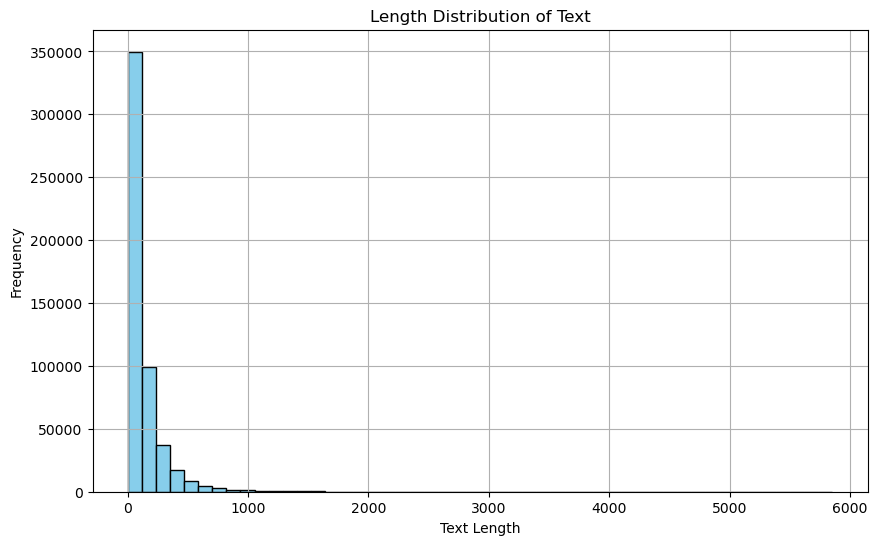

In [8]:
import matplotlib.pyplot as plt

# Calculate the length of each text
text_lengths = df_cleaned['text'].apply(len)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(text_lengths, bins=50, color='skyblue', edgecolor='black')
plt.title('Length Distribution of Text')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [45]:
# Calculate the number of comments longer than 100 characters
comments_longer_than_100 = df_cleaned[df_cleaned['text'].str.len() > 512]

# Calculate the percentage of comments longer than 100 characters
percentage_longer_than_100 = (len(comments_longer_than_100) / len(df_cleaned)) * 100

print(f"Percentage of comments longer than 512 characters: {percentage_longer_than_100:.2f}%")


Percentage of comments longer than 512 characters: 3.42%
